# Advanced Image Classification with ImageNet

In this assignment, you will be asked to develop a convolutional neural network (CNN) to classify images from the CIFAR-100 dataset. At each step, you'll be guided through the process of developing a model architecture to solve a problem. Your goal is to create a CNN that attains at least 55% accuracy on the validation set.

### The CIFAR-100 Dataset

The [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 colour images in 100 classes, with 600 images per class. There are 50000 training images and 10000 test images. The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 500 images from each class.

### Tools

You will use Keras with TensorFlow to develop your CNN. For this assignment, it's strongly recommended that you use a GPU to accelerate your training, or else you might find it difficult to train your network in a reasonable amount of time. If you have a computer with a GPU that you wish to use, you can follow the [TensorFlow instructions](https://www.tensorflow.org/install/) for installing TensorFlow with GPU support. Otherwise, you can use [Google Colab](https://colab.research.google.com/) to complete this assignment. Colab provides free access to GPU-enabled machines. If you run into any issues, please contact us as soon as possible so that we can help you resolve them.

## Task 1: Data Exploration and Preprocessing (Complete or Incomplete)
### 1a: Load and Explore the Dataset
- Use the code below to download the dataset.
- Explore the dataset: examine the shape of the training and test sets, the dimensions of the images, and the number of classes. Show a few examples from the training set.

In [1]:
from keras.datasets import cifar100
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical

# Load the CIFAR-100 dataset
(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

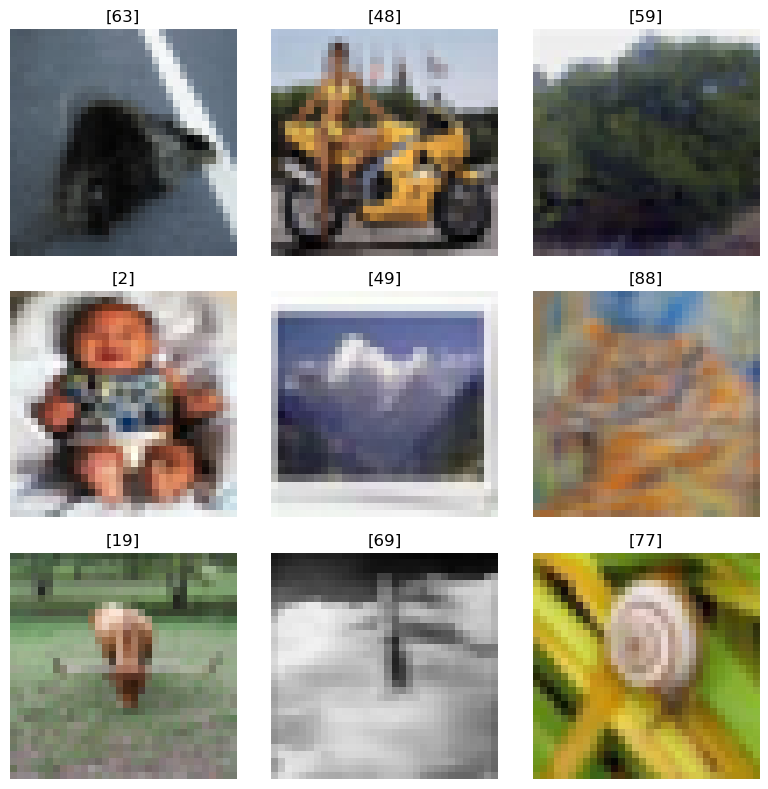

In [2]:
# Your code here

import matplotlib.pyplot as plt


indices = np.random.choice(X_train.shape[0], 9, replace=False)
selected_images = X_train[indices]
selected_labels = y_train[indices]

fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(selected_images[i])
    ax.set_title(f"{selected_labels[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

### 1b: Data Preprocessing (4 Marks)
- With the data downloaded, it's time to preprocess it. Start by normalizing the images so that they all have pixel values in the range [0, 1].
- Next, convert the labels to one-hot encoded vectors.
- Finally, split the training set into training and validation sets. Use 80% of the training set for training and the remaining 20% for validation.

In [3]:
# Your code here
from sklearn.model_selection import train_test_split

num_classes = 100

y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (40000, 32, 32, 3), (40000, 100)
Validation set shape: (10000, 32, 32, 3), (10000, 100)
Test set shape: (10000, 32, 32, 3), (10000, 100)


## Task 2: Model Development (Complete or Incomplete)
### Task 2a: Create a Baseline CNN Model
- Design a CNN architecture. Your architecture should use convolutional layers, max pooling layers, and dense layers. You can use any number of layers, and you can experiment with different numbers of filters, filter sizes, strides, padding, etc. The design doesn't need to be perfect, but it should be unique to you.
- Print out the model summary.

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Your code here

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                        

### Task 2b: Compile the model

- Select an appropriate loss function and optimizer for your model. These can be ones we have looked at already, or they can be different. 
- Briefly explain your choices (one or two sentences each).
- <b>Loss function:</b> Categorical Crossentropy is suitable for multi-class classification problems which measures the discrepancy between the predicted probability distribution and the true distribution, effectively guiding the model to output probabilities close to the true class labels.
- <b>Optimizer:</b> The Adam optimizer provides adaptive learning rates for each parameter. It generally results in faster convergence and improved performance on complex problems like image classification.

In [5]:
from keras import optimizers

# Your code here

from keras.metrics import AUC, Precision, Recall

model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['AUC', 'accuracy'])

## Task 3: Model Training and Evaluation (Complete or Incomplete)
### Task 3a: Train the Model

- Train your model for an appropriate number of epochs. Explain your choice of the number of epochs used - you can change this number before submitting your assignment.
- Use a batch size of 32.
- Use the validation set for validation.

In [6]:
# Your code here

epochs = 50 # 15*3+5
batch_size = 32

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val)
)

Epoch 1/15
1250/1250 [==============================] - 75s 58ms/step - loss: 4.2966 - auc: 0.6909 - accuracy: 0.0565 - val_loss: 3.8410 - val_auc: 0.7979 - val_accuracy: 0.1083
Epoch 2/15
1250/1250 [==============================] - 63s 50ms/step - loss: 3.7802 - auc: 0.8112 - accuracy: 0.1161 - val_loss: 3.3789 - val_auc: 0.8649 - val_accuracy: 0.1873
Epoch 3/15
1250/1250 [==============================] - 67s 54ms/step - loss: 3.4227 - auc: 0.8561 - accuracy: 0.1766 - val_loss: 3.2202 - val_auc: 0.8769 - val_accuracy: 0.2167
Epoch 4/15
1250/1250 [==============================] - 68s 55ms/step - loss: 3.1097 - auc: 0.8869 - accuracy: 0.2296 - val_loss: 2.7564 - val_auc: 0.9199 - val_accuracy: 0.3030
Epoch 5/15
1250/1250 [==============================] - 70s 56ms/step - loss: 2.8530 - auc: 0.9061 - accuracy: 0.2792 - val_loss: 2.9576 - val_auc: 0.8921 - val_accuracy: 0.2762
Epoch 6/15
1250/1250 [==============================] - 69s 55ms/step - loss: 2.6294 - auc: 0.9212 - accuracy:

### Task 3b: Accuracy and other relevant metrics on the test set

- Report the accuracy of your model on the test set.
- While accuracy is a good metric, there are many other ways to numerically evaluate a model. Report at least one other metric, and explain what it measures and how it is calculated.

- <b>Accuracy:</b> 0.4254
- <b>Other metric:</b> AUC
- <b>Reason for selection:</b> Accuracy is a straightforward and commonly used metric to evaluate the proportion of correct predictions made by the model. And, AUC provides a more nuanced view of the model's performance, especially in imbalanced datasets, by evaluating the trade-off between true positive rates and false positive rates at various threshold settings.
- <b>Value of metric:</b> Accuracy is typically reported as a fraction or percentage of correctly classified instances. AUC is reported as a value between 0 and 1, with higher values indicating better performance.
- <b>Interpretation of metric value:</b> An accuracy of 0.4254 indicates that the model correctly classified 42.54% of the test instances. An AUC of 0.9193 indicates good discriminative ability, though there is still the room for improvement.


In [7]:
# Your code here

test_loss, test_auc, test_accuracy = model.evaluate(X_test, y_test)

print(f'Test Accuracy: {test_accuracy}')
print(f'Test AUC: {test_auc}')

313/313 [==============================] - 6s 20ms/step - loss: 2.3629 - auc: 0.9193 - accuracy: 0.4254
Test Accuracy: 0.4253999888896942
Test AUC: 0.9193165302276611


### Task 3c: Visualize the model's learning

- Plot the training accuracy and validation accuracy with respect to epochs.
- Select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.
- Briefly discuss the results. What do the plots show? Do the results make sense? What do the classification probabilities indicate?

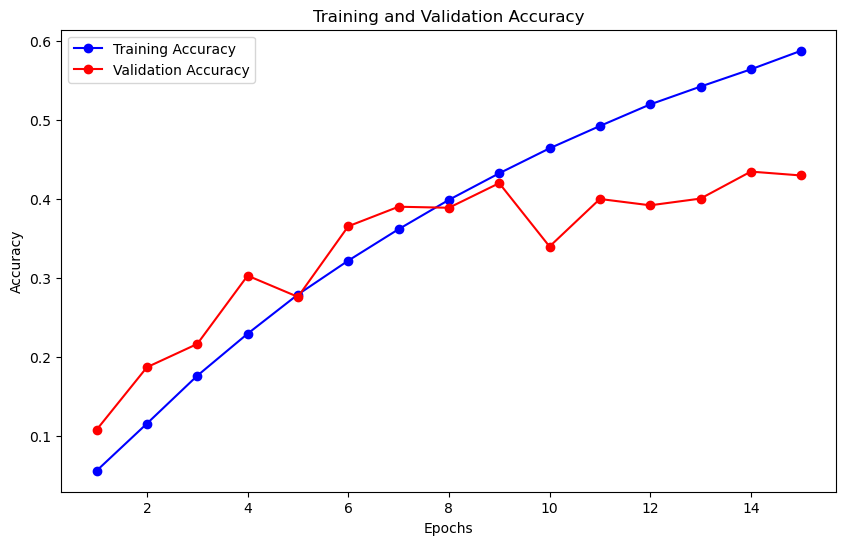

313/313 [==============================] - 6s 19ms/step


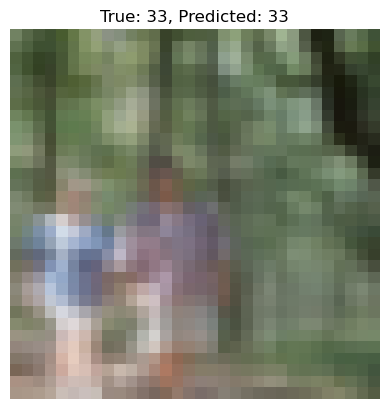

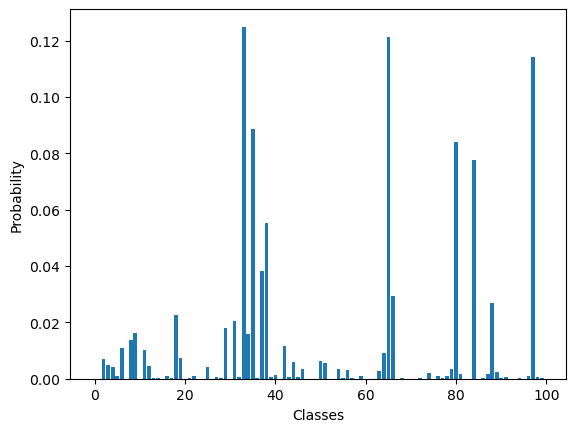

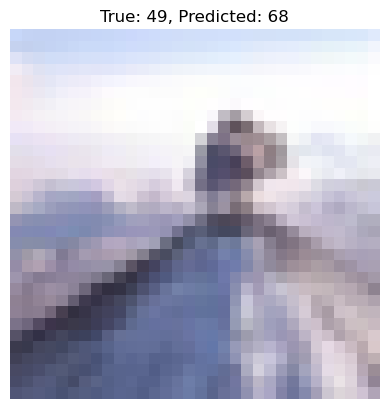

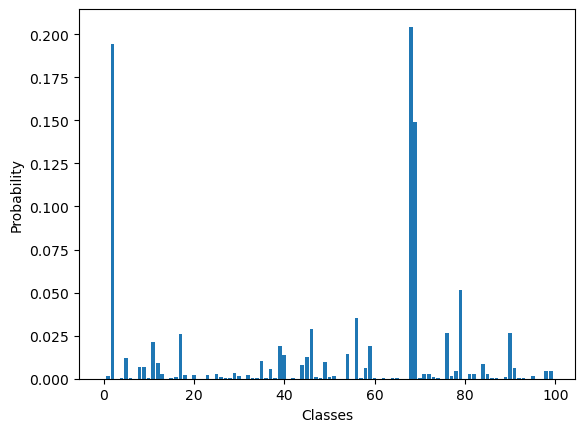

In [ ]:
# Your code here

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Task 4: Model Enhancement (Complete or Incomplete)
### Task 4a: Implementation of at least one advanced technique

- Now it's time to improve your model. Implement at least one technique to improve your model's performance. You can use any of the techniques we have covered in class, or you can use a technique that we haven't covered. If you need inspiration, you can refer to the [Keras documentation](https://keras.io/).
- Explain the technique you used and why you chose it.

Answer: I used data augmentation to improve the model's performance by applying random transformations to the training images. The techniques include rotation, width and height shifts, shear, zoom, and horizontal flips were used to introduce variability, helping the model generalize better to new data and prevent overfitting. 

- If you used a technique that requires tuning, explain how you selected the values for the hyperparameters.

Answer: These specific hyperparameters were chosen based on common practices to balance augmentation intensity and maintain image integrity. This approach should enhance the model's robustness and accuracy on the CIFAR-100 dataset.

In [16]:
# Your code here

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)


"\nfrom tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint\nfrom tensorflow.keras.preprocessing.image import ImageDataGenerator\n\n# Improving the model\nmodel = Sequential()\n\nmodel.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))\nmodel.add(MaxPooling2D(pool_size=(2,2)))  \nmodel.add(BatchNormalization())\n\nmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))\nmodel.add(MaxPooling2D(pool_size=(2,2)))  \nmodel.add(BatchNormalization())\n\nmodel.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))\nmodel.add(MaxPooling2D(pool_size=(2,2)))  \nmodel.add(BatchNormalization())\n\nmodel.add(Flatten())\nmodel.add(Dense(256, activation='relu'))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(128, activation='relu'))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(100, activation='softmax'))\n\n# Define early stopping\nearly_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weigh

### Task 4b: Evaluation of the enhanced model

- Re-train your model using the same number of epochs as before.
- Compare the accuracy and other selected metric on the test set to the results you obtained before.
- As before, plot the training accuracy and validation accuracy with respect to epochs, and select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.

In [22]:
# Your code here


history_augmented = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=75 # 50+20+5, 
                    callbacks=[early_stopping])



Epoch 1/5
1250/1250 [==============================] - 167s 133ms/step - loss: 1.4475 - auc: 0.9706 - accuracy: 0.6011 - val_loss: 1.7696 - val_auc: 0.9500 - val_accuracy: 0.5461
Epoch 2/5
1250/1250 [==============================] - 163s 131ms/step - loss: 1.4259 - auc: 0.9713 - accuracy: 0.6059 - val_loss: 2.0009 - val_auc: 0.9362 - val_accuracy: 0.5138
Epoch 3/5
1250/1250 [==============================] - 169s 135ms/step - loss: 1.4337 - auc: 0.9708 - accuracy: 0.6030 - val_loss: 1.8830 - val_auc: 0.9427 - val_accuracy: 0.5338
Epoch 4/5
1250/1250 [==============================] - 196s 156ms/step - loss: 1.4311 - auc: 0.9704 - accuracy: 0.6043 - val_loss: 1.7610 - val_auc: 0.9504 - val_accuracy: 0.5517
Epoch 5/5
1250/1250 [==============================] - 169s 136ms/step - loss: 1.4069 - auc: 0.9708 - accuracy: 0.6092 - val_loss: 1.8145 - val_auc: 0.9475 - val_accuracy: 0.5448


"\n\ntest_loss, test_acc = improved_model.evaluate(X_test1, y_test)\nprint(f'Test accuracy after improvements: {test_acc}')\n"

### Task 4c: Discussion of the results

- Briefly discuss the results. 
- Did the model's performance improve? 
- Why do you think this is?
- Do you think there is room for further improvement? Why or why not?
- What other techniques might you try in the future?
- Your answer should be no more than 200 words.

# Your answer here

Please see the answers below to the above questions.

Model Performance:
The model's performance showed slight improvement in validation accuracy, reaching up to 55.17% after implementing data augmentation. This indicates a better generalization to the validation data compared to previous results without augmentation.

Reasons for Improvement:
The improvement is likely due to the data augmentation techniques, which introduced variability in the training data. This helped the model learn more robust features, reducing overfitting and improving its ability to generalize to new, unseen data.

Room for Further Improvement:
Yes, there is room for further improvement. The validation accuracy is still relatively low, and the validation loss suggests that the model may be struggling with certain aspects of the data.

Future Techniques:

Regularization - Adding dropout layers or using L2 regularization can further reduce overfitting.

Ensembling - Combining predictions from multiple models can often yield better performance than a single model.

Transfer Learning - Tuning up a pre-trained model like ResNet or EfficientNet on CIFAR-100 could lead to significant improvements.

Overall, while the data augmentation has helped, exploring and implementing these additional techniques could further enhance the model's performance on the dataset.

## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_1.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.